In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/DACON/K-League

/content/drive/MyDrive/DACON/K-League


In [3]:
!pip install koreanize-matplotlib
!pip install catboost
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.7 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import numpy as np
import math
from google.colab import drive
from tqdm import tqdm
from pathlib import Path
from mplsoccer import Pitch
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc
import matplotlib.patches as mpatches
import seaborn as sns
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
import koreanize_matplotlib
from sklearn.preprocessing import StandardScaler

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
# Train 원본 로딩
train_df = pd.read_csv("./train.csv")
train_df = train_df.sort_values(["game_episode", "time_seconds", "action_id"]).reset_index(drop=True)
train_df["is_train"] = 1

# Test 원본 로딩
test_meta = pd.read_csv("./test.csv")
BASE_TEST_DIR = "/content/drive/MyDrive/DACON/K-League/test"

test_meta["path"] = (
    BASE_TEST_DIR + "/"
    + test_meta["game_id"].astype(str) + "/"
    + test_meta["game_episode"].astype(str)
    + ".csv"
)

episode_dfs = []

for _, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
    ep_df = pd.read_csv(row["path"]).reset_index(drop=True)
    ep_df["game_id"] = row["game_id"]
    ep_df["game_episode"] = row["game_episode"]
    ep_df["is_train"] = 0
    episode_dfs.append(ep_df)

test_df = pd.concat(episode_dfs, ignore_index=True)
print(train_df.shape, test_df.shape)

# train + test 병합
df = pd.concat([train_df, test_df], ignore_index=True)
print(df.shape)

use_cols = [
    'game_id',
    'game_day', 'game_date',
    'home_score', 'away_score',
    'venue',
    'home_team_name_ko', 'away_team_name_ko'   # EDA용
]
# match_info 병합
df_match = pd.read_csv("./match_info.csv")
df_copy = df.merge(df_match[use_cols], on='game_id', how='left')

  0%|          | 1/2414 [00:00<23:02,  1.74it/s]


KeyboardInterrupt: 

In [ ]:
df_copy.to_csv('df.csv', index=False)

In [6]:
# ================여기서부터 시작===================
df_copy = pd.read_csv("./df.csv")
df_copy

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,...,is_home,game_episode,is_train,game_day,game_date,home_score,away_score,venue,home_team_name_ko,away_team_name_ko
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,True,126283_1,1,1,2024-03-01 05:00:00,1,0,문수월드컵경기장,울산 HD FC,포항 스틸러스
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,True,126283_1,1,1,2024-03-01 05:00:00,1,0,문수월드컵경기장,울산 HD FC,포항 스틸러스
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,True,126283_1,1,1,2024-03-01 05:00:00,1,0,문수월드컵경기장,울산 HD FC,포항 스틸러스
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,True,126283_1,1,1,2024-03-01 05:00:00,1,0,문수월드컵경기장,울산 HD FC,포항 스틸러스
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,True,126283_1,1,1,2024-03-01 05:00:00,1,0,문수월드컵경기장,울산 HD FC,포항 스틸러스
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409826,153392,2,107,2905.168,4657,213491,2631,Carry,NaN,60.501840,...,True,153392_107,0,38,2024-11-24 05:00:00,-1,-1,대전월드컵경기장,대전 하나 시티즌,제주SK FC
409827,153392,2,107,2906.467,4657,213491,2632,Pass,Successful,65.639595,...,True,153392_107,0,38,2024-11-24 05:00:00,-1,-1,대전월드컵경기장,대전 하나 시티즌,제주SK FC
409828,153392,2,108,2958.600,4657,287281,2638,Pass_Corner,Successful,104.325690,...,True,153392_108,0,38,2024-11-24 05:00:00,-1,-1,대전월드컵경기장,대전 하나 시티즌,제주SK FC
409829,153392,2,108,2961.200,4657,213491,2640,Pass,Successful,85.267560,...,True,153392_108,0,38,2024-11-24 05:00:00,-1,-1,대전월드컵경기장,대전 하나 시티즌,제주SK FC


In [7]:
df_copy = df_copy.sort_values(["game_id", "game_episode", "time_seconds"]).reset_index(drop=True)

In [8]:
# 2. 대분류 game_episode(게임 ID + 전ㆍ후반)  / 중분류 time_seconds : 동에피소드 시간순서
if 'type_name' in df_copy.columns:
    df_copy = df_copy.rename(columns={'type_name': 'action_type'})
print("train/test + match_info 병합 = df_copy")
print(df_copy.info())

train/test + match_info 병합 = df_copy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409831 entries, 0 to 409830
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            409831 non-null  int64  
 1   period_id          409831 non-null  int64  
 2   episode_id         409831 non-null  int64  
 3   time_seconds       409831 non-null  float64
 4   team_id            409831 non-null  int64  
 5   player_id          409831 non-null  int64  
 6   action_id          409831 non-null  int64  
 7   action_type        409831 non-null  object 
 8   result_name        248448 non-null  object 
 9   start_x            409831 non-null  float64
 10  start_y            409831 non-null  float64
 11  end_x              407417 non-null  float64
 12  end_y              407417 non-null  float64
 13  is_home            409831 non-null  bool   
 14  game_episode       409831 non-null  object 
 15  is_train      

In [9]:
df_copy.value_counts("action_type")

,count
action_type,
Pass,204612
Carry,94037
Recovery,31703
Interception,12817
Duel,10154
Tackle,9435
Throw-In,7904
Clearance,7527
Intervention,7044


--- Pipeline Start ---
Filtered Pass Events (Train Only: True): ['Pass' 'Pass_Corner' 'Goal Kick' 'Throw-In' 'Pass_Freekick' 'Cross']
Players with >= 5 passes: 438

--- Cluster Summary (Check this to define roles) ---
            start_x_mean  start_y_mean  pass_dist_mean  forward_mean
cluster_id                                                          
0              61.866001     49.769382       13.821746      0.475300
1              47.424854     32.852221       17.244856      0.624469
2              63.373416     27.772314       12.860367      0.463221
3              11.547747     32.940832       30.555394      0.956800
4              44.086435     50.512961       18.399140      0.645007
5              50.727673     13.848040       17.135792      0.614363


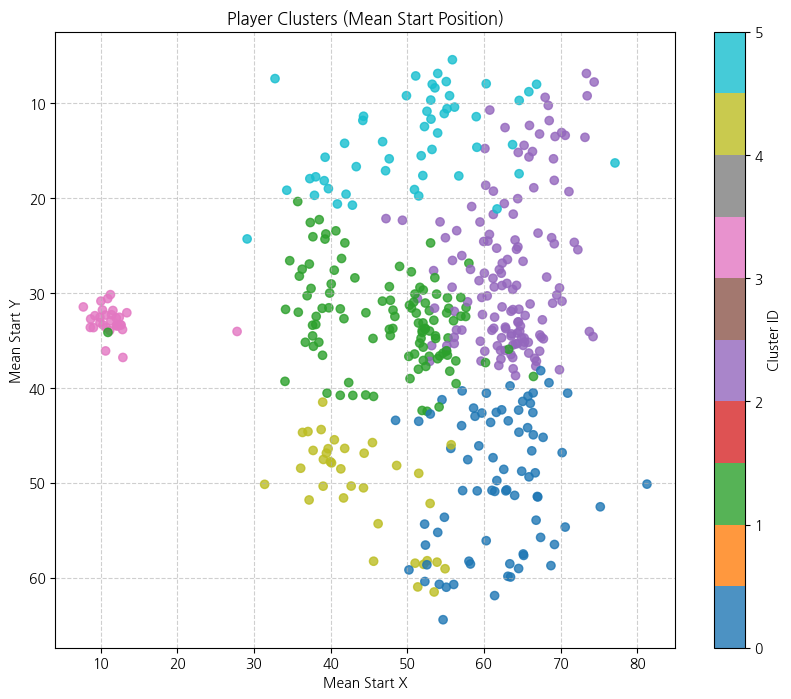


--- Final Role Label Counts in Original DF ---
player_role_label
mid_temp           148387
attack_temp         74091
mid2_temp           58155
right_wing_temp     53722
defense_temp        51182
GK_temp             23624
unknown               670
Name: count, dtype: int64
--- Pipeline End ---


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. 설정 및 상수 정의 (Configuration)

# 분석 대상 패스 이벤트 타입 정의
PASS_EVENTS = [
    "Pass", "Pass_Freekick", "Pass_Corner",
    "Throw-In", "Goal Kick", "Cross"
]

INITIAL_ROLE_MAP = {
    0: "right_wing_temp",
    1: "mid_temp",
    2: "attack_temp",
    3: "GK_temp",
    4: "defense_temp",
    5: "mid2_temp"
}

# 함수 정의

def load_and_filter_data(df_origin, train_only=True):
    """
    원본 데이터에서 패스 이벤트만 추출하고,
    데이터 누수 방지를 위해 학습 데이터만 필터링합니다.
    """
    # 1. 데이터 누수 방지: 학습 데이터(is_train == 1)만 선택
    if train_only:
        df_filtered = df_origin[df_origin["is_train"] == 1].copy()
    else:
        df_filtered = df_origin.copy()

    # 2. 패스 관련 이벤트만 필터링
    df_pass = df_filtered[df_filtered["action_type"].isin(PASS_EVENTS)].copy()

    print(f"Filtered Pass Events (Train Only: {train_only}): {df_pass['action_type'].unique()}")
    return df_pass

def create_pass_features(df_pass, min_passes=5):
    """
    패스 거리, 방향 등의 기본 피처를 생성하고
    패스 횟수가 너무 적은 선수를 제외합니다.
    """
    # 기본 피처 계산
    df_pass["dx"] = df_pass["end_x"] - df_pass["start_x"]
    df_pass["dy"] = df_pass["end_y"] - df_pass["start_y"]
    df_pass["pass_dist"] = np.sqrt(df_pass["dx"]**2 + df_pass["dy"]**2)
    df_pass["forward"] = (df_pass["dx"] > 0).astype(int)
    df_pass["side_move"] = df_pass["dy"].abs()

    # 최소 패스 횟수 미만 선수 제거
    pass_counts = df_pass.groupby("player_id").size()
    valid_players = pass_counts[pass_counts >= min_passes].index

    df_pass_valid = df_pass[df_pass["player_id"].isin(valid_players)].copy()
    print(f"Players with >= {min_passes} passes: {len(valid_players)}")

    return df_pass_valid

def calculate_player_stats(df_pass_valid):
    """
    선수별로 패스 데이터의 평균/표준편차를 집계하여
    클러스터링에 사용할 입력 데이터를 만듭니다.
    """
    # 선수별 집계 (Aggregation)
    agg_rules = {
        "start_x": ["mean"], "start_y": ["mean"],
        "end_x": ["mean"],   "end_y": ["mean"],
        "dx": ["mean"],      "dy": ["mean"],
        "pass_dist": ["mean", "std"],
        "forward": ["mean"], "side_move": ["mean"],
    }
    player_stats = df_pass_valid.groupby("player_id").agg(agg_rules)

    # MultiIndex 컬럼 평탄화 (예: ('start_x', 'mean') -> 'start_x_mean')
    player_stats.columns = ['_'.join(col).strip() for col in player_stats.columns.values]

    # 결측치 처리 (std 계산 시 패스가 1개면 NaN 발생 가능 -> 0으로 대체)
    player_stats_flat = player_stats.fillna(0)

    return player_stats_flat

def perform_clustering(player_stats_df, n_clusters=6, random_state=42):
    """
    집계된 선수 데이터를 스케일링하고 KMeans 클러스터링을 수행합니다.
    """
    # 스케일링 (StandardScaler)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(player_stats_df)

    # KMeans 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)

    # 결과 데이터프레임에 클러스터 ID 추가
    results_df = player_stats_df.copy()
    results_df['cluster_id'] = labels

    return results_df, kmeans, scaler

def visualize_clusters(stats_df_with_cluster, title="Player Clusters (Mean Start Position)"):
    """
    클러스터링 결과를 시각화합니다 (평균 시작 위치 기준).
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        stats_df_with_cluster["start_x_mean"],
        stats_df_with_cluster["start_y_mean"],
        c=stats_df_with_cluster["cluster_id"],
        cmap="tab10",
        alpha=0.8
    )
    plt.colorbar(scatter, label="Cluster ID")
    plt.xlabel("Mean Start X")
    plt.ylabel("Mean Start Y")
    plt.title(title)
    plt.gca().invert_yaxis() # 축구장 좌표계 특성 반영
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# 3. 메인 실행 파이프라인 (Execution Pipeline)

print("--- Pipeline Start ---")

# 1) 데이터 로드 및 필터링 (Train 데이터만 사용!)
df_pass_train = load_and_filter_data(df_copy, train_only=True)

# 2) 피처 생성 및 유효 선수 필터링
df_pass_valid = create_pass_features(df_pass_train, min_passes=5)

# 3) 선수별 통계 집계
player_stats_flat = calculate_player_stats(df_pass_valid)

# 4) 클러스터링 수행 (k=6)
clustered_stats, kmeans_model, scaler_model = perform_clustering(player_stats_flat, n_clusters=6)

# 5) 클러스터 특성 확인 (이 결과를 보고 ROLE_MAP을 수정해야 함)
cluster_summary = clustered_stats.groupby("cluster_id").mean()
print("\n--- Cluster Summary (Check this to define roles) ---")
print(cluster_summary[['start_x_mean', 'start_y_mean', 'pass_dist_mean', 'forward_mean']])

# 6) 시각화 확인
visualize_clusters(clustered_stats)

# -------------------------------------------------
# 결과 매핑 및 원본 데이터 업데이트
# -------------------------------------------------

# player_id -> cluster_id 매핑 딕셔너리 생성
id2cluster = clustered_stats['cluster_id'].to_dict()

# cluster_id -> 역할 이름(Role Label) 매핑 생성
id2role_label = {pid: INITIAL_ROLE_MAP.get(cid, "unknown") for pid, cid in id2cluster.items()}

# 원본 df_copy에 결과 반영
# 훈련 데이터에만 존재하는 선수들이므로, 매핑되지 않은 선수는 'unknown' 처리
df_copy["player_role_pass"] = df_copy["player_id"].map(id2cluster)
df_copy["player_role_label"] = df_copy["player_id"].map(id2role_label).fillna("unknown")

print("\n--- Final Role Label Counts in Original DF ---")
print(df_copy['player_role_label'].value_counts())
print("--- Pipeline End ---")

In [11]:
# 0) 에피소드 내 시간 순으로 정렬
order_col = "time_seconds"   # 또는 "action_id"
df_copy = df_copy.sort_values(["game_episode", order_col]).copy()

# 1) 몇 개 이전까지 볼지 설정
n_prev = 1

# 2) 이전 이벤트에서 가져올 컬럼들
base_cols = ["end_x", "end_y",'action_type', "result_name"]

for i in range(1, n_prev + 1):
    shifted = (
        df_copy
        .groupby("game_episode")[base_cols]
        .shift(i)        # i번째 이전 이벤트
    )

    # 컬럼 이름 붙이기
    shifted.columns = [f"prev{i}_{col}" for col in base_cols]

    # 원본 df_copy에 붙이기
    df_copy = pd.concat([df_copy, shifted], axis=1)

df_copy.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,away_score,venue,home_team_name_ko,away_team_name_ko,player_role_pass,player_role_label,prev1_end_x,prev1_end_y,prev1_action_type,prev1_result_name
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,0.0,right_wing_temp,NaN,NaN,NaN,NaN
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,4.0,defense_temp,31.322445,38.274752,Pass,Successful
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,2.0,attack_temp,37.371285,30.632980,Pass,Successful
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,2.0,attack_temp,38.391570,24.613144,Carry,NaN
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,5.0,mid2_temp,34.573350,5.545468,Pass,Successful


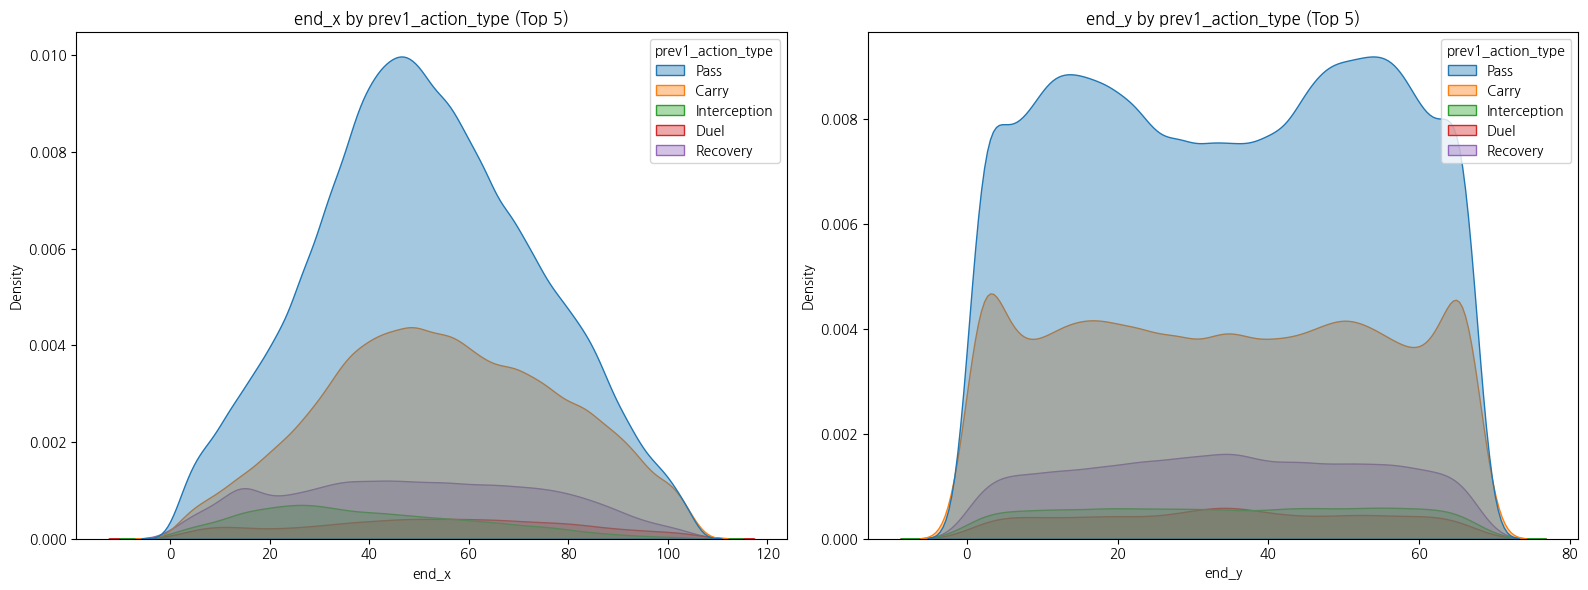

In [12]:
#df_copy 1-step의 상위 5개의 type_name의 행동 분포확인
# Top 5 prev_action_type 선택
topN = df_copy["prev1_action_type"].value_counts().head(5).index.tolist()
plot = df_copy[df_copy["prev1_action_type"].isin(topN)]

# Figure & subplots 준비
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) end_x KDE
sns.kdeplot(
    data=plot, x="end_x", hue="prev1_action_type",
    fill=True, alpha=0.4, ax=axes[0]
)
axes[0].set_title("end_x by prev1_action_type (Top 5)")

# 2) end_y KDE
sns.kdeplot(
    data=plot, x="end_y", hue="prev1_action_type",
    fill=True, alpha=0.4, ax=axes[1]
)
axes[1].set_title("end_y by prev1_action_type (Top 5)")

plt.tight_layout()
plt.show()

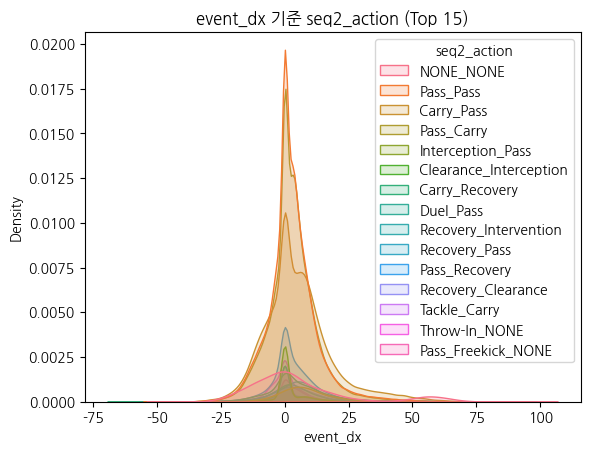

In [13]:
#1-step + 2-step 조합
df_copy["prev2_action_type"] =df_copy.groupby("game_episode")["action_type"].shift(2)

df_copy["prev1_action_type"]  = df_copy["prev1_action_type"].fillna("NONE")
df_copy["prev2_action_type"] = df_copy["prev2_action_type"].fillna("NONE")

df_copy["seq2_action"] = df_copy["prev1_action_type"] + "_" + df_copy["prev2_action_type"]

#EDA용 dx,dy
df_copy["event_dx"] = df_copy["end_x"] - df_copy["start_x"]
df_copy["event_dy"] = df_copy["end_y"] - df_copy["start_y"]

# seq2_action 상위 15개 분포 확인 (event_dx기준)
topK = df_copy["seq2_action"].value_counts().head(15).index.tolist()
df_top = df_copy[df_copy["seq2_action"].isin(topK)]
sns.kdeplot(data=df_top, x="event_dx", hue="seq2_action", fill=True, alpha=0.2)
plt.title('event_dx 기준 seq2_action (Top 15)')
plt.show()

#seq2_action_top 변수 df에 추가
df_copy["seq2_action_top"] = df_copy["seq2_action"].where(df_copy["seq2_action"].isin(topK), "OTHER")

#사용안하는 변수 삭제
df_copy = df_copy.drop(columns=["event_dx", "event_dy", "seq2_action"])

In [14]:
# 2. DL/Goal/Penalty Features 추가
def add_dl_features(df):
    # 이전 시작 위치
    df['prev_start_x'] = df.groupby('game_episode')['start_x'].shift(1)
    df['prev_start_y'] = df.groupby('game_episode')['start_y'].shift(1)

    dx = df['start_x'] - df['prev_start_x'] # Series
    dy = df['start_y'] - df['prev_start_y'] # Series

    # 현재 시간 - 과거 시간
    dt = df['time_seconds'] - df.groupby('game_episode')['time_seconds'].shift(1)
    dt = dt.fillna(1.0).replace(0, 0.1)

    # 속도 계산
    df['legal_speed'] = np.sqrt(dx**2 + dy**2) / dt
    df['legal_speed'] = df['legal_speed'].fillna(0.0)

    df['move_angle'] = np.arctan2(dy, dx)
    df['move_angle_sin'] = np.sin(df['move_angle']).fillna(0.0)
    df['move_angle_cos'] = np.cos(df['move_angle']).fillna(0.0)

    df['x_zone'] = (df['start_x'] / (105 / 7)).astype(int).clip(0, 6)
    df['y_lane'] = pd.cut(
        df['start_y'],
        bins=[0, 68/3, 2*68/3, 68],
        labels=[0, 1, 2],
        include_lowest=True
    ).astype(int)

    # Goal Value 패널티 박스 플레이 가정
    OPP_GOAL_X, OPP_GOAL_Y = 105, 34
    df['dist_to_opp_goal'] = np.sqrt((df['start_x'] - OPP_GOAL_X)**2 + (df['start_y'] - OPP_GOAL_Y)**2)
    df['angle_to_opp_goal'] = np.arctan2(OPP_GOAL_Y - df['start_y'], OPP_GOAL_X - df['start_x'])
    df['angle_to_opp_goal_sin'] = np.sin(df['angle_to_opp_goal']).fillna(0.0)
    df['angle_to_opp_goal_cos'] = np.cos(df['angle_to_opp_goal']).fillna(0.0)

    PENALTY_LINE_X = 105 - 16.5  # 88.5m
    PENALTY_CENTER_Y = 34
    df['dist_to_opp_box_center'] = np.sqrt(
        (df['start_x'] - PENALTY_LINE_X)**2 + (df['start_y'] - PENALTY_CENTER_Y)**2
    )

    # 추가: 에피소드 내 이벤트 순번 (0, 1, 2, ...)
    df['episode_event_index'] = df.groupby('game_episode').cumcount()

    return df

df_copy = add_dl_features(df_copy)

# 실제 시간 추가
df_copy["match_minutes"] = df_copy["time_seconds"]/60 + (df_copy["period_id"]-1)*45

df_copy.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,move_angle_cos,x_zone,y_lane,dist_to_opp_goal,angle_to_opp_goal,angle_to_opp_goal_sin,angle_to_opp_goal_cos,dist_to_opp_box_center,episode_event_index,match_minutes
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,0.000000,3,1,52.584313,0.009786,0.009785,0.999952,36.085464,0,0.011117
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,-0.975361,2,1,73.101872,-0.056127,-0.056097,0.998425,56.635419,1,0.061117
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,0.582957,2,1,67.712480,0.049746,0.049725,0.998763,51.239461,2,0.082800
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,0.167104,2,1,67.266604,0.140004,0.139547,0.990215,50.980073,3,0.136667
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,-0.201285,2,0,75.762127,0.377727,0.368809,0.929505,60.730940,4,0.193883


In [ ]:
# =============================================================================
# 1. 공간 및 지역 피처 (Spatial & Zone Features)
# 의도: 현재 공의 위치가 경기장의 어느 구역이며, 골대와 얼마나 인접해 있는가?
# =============================================================================
def add_spatial_features(df):
    # [구역화] 경기장 가로(105m)를 7등분: 0(우리쪽 골대) ~ 6(상대쪽 골대)
    # 어떤 지역에서 패스가 주로 시작되는지 파악
    df['x_zone'] = (df['start_x'] / (105 / 7)).astype(int).clip(0, 6)

    # [레인화] 경기장 세로(68m)를 3등분: 0(좌측), 1(중앙), 2(우측)
    # 측면 공격인지 중앙 빌드업인지 구분
    df['y_lane'] = pd.cut(df['start_y'], bins=[0, 68/3, 2*68/3, 68],
                          labels=[0, 1, 2], include_lowest=True).astype(int)

    # [공격 거리] 상대 골대 중앙(105, 34)까지의 직선 거리
    # 거리가 가까울수록 슛이나 결정적인 패스 확률 증가
    df['dist_to_opp_goal'] = np.sqrt((df['start_x'] - 105)**2 + (df['start_y'] - 34)**2)

    # [수비 거리] 우리 골대 중앙(0, 34)까지의 직선 거리
    # 우리 진영 깊숙한 곳인지 확인 (위험 지역에서의 빌드업 판단)
    df['dist_to_my_goal'] = np.sqrt((df['start_x'] - 0)**2 + (df['start_y'] - 34)**2)

    # [박스 타겟] 상대 패널티 박스 정면(88.5, 34)과의 거리
    # 찬스 메이킹이 일어나는 핵심 지역과의 인접도
    df['dist_to_opp_box_center'] = np.sqrt((df['start_x'] - 88.5)**2 + (df['start_y'] - 34)**2)

    # [사이드라인] 현재 위치에서 가장 가까운 터치라인까지의 거리
    # 압박을 받기 쉬운 가장자리인지, 자유로운 중앙인지 판단
    df['dist_to_sideline'] = df['start_y'].apply(lambda y: min(y, 68 - y))

    return df

# =============================================================================
# 2. 물리 및 동적 흐름 피처 (Physics & Flow Features)
# 의도: 이전 동작으로부터 현재까지 공과 선수가 어떻게 이동(가속/방향전환)했는가?
# =============================================================================
def add_physics_features(df):
    # [직전 좌표] 바로 직전 이벤트의 시작 위치를 가져옴
    df['prev_start_x'] = df.groupby('game_episode')['start_x'].shift(1)
    df['prev_start_y'] = df.groupby('game_episode')['start_y'].shift(1)

    # [변위] 이전 위치에서 현재 위치까지의 x, y축 이동 거리
    dx = df['start_x'] - df['prev_start_x']
    dy = df['start_y'] - df['prev_start_y']

    # [시간차] 이벤트 사이의 경과 시간 (나눗셈 에러 방지를 위해 최소 0.1초 설정)
    dt = (df['time_seconds'] - df.groupby('game_episode')['time_seconds'].shift(1)).fillna(1.0).replace(0, 0.1)

    # [이동 속도] 단위 시간당 이동 거리 (m/s)
    # 역습 상황처럼 빠르게 전진 중인지, 지공 상황인지 구분
    df['legal_speed'] = (np.sqrt(dx**2 + dy**2) / dt).fillna(0.0)

    # [이동 각도] 현재 이동 중인 방향을 라디안 각도로 계산
    move_angle = np.arctan2(dy, dx)
    # [각도 분해] 모델이 각도의 연속성을 이해하도록 Sin/Cos 값으로 변환
    # (예: 359도와 1도는 수치상 멀지만 물리적으론 가깝기 때문)
    df['move_angle_sin'] = np.sin(move_angle).fillna(0.0)
    df['move_angle_cos'] = np.cos(move_angle).fillna(0.0)

    return df

# =============================================================================
# 3. 과거 맥락(Lag) 피처 (Sequence Context Features)
# 의도: 지금 패스하기 직전 3단계 동안 어떤 일이 있었는가? (흐름 파악)
# =============================================================================
def add_lag_features(df, n_shifts=3):
    # 추적 항목: 종료 위치(x, y), 행동 종류(action), 성공 여부(result)
    base_cols = ["end_x", "end_y", "action_type", "result_name"]
    grp = df.groupby("game_episode")

    for k in range(1, n_shifts + 1):
        # [과거 데이터] k단계 전의 기록을 현재 시점으로 당겨옴
        shifted = grp[base_cols].shift(k)
        shifted.columns = [f"prev{k}_{c}" for c in base_cols]
        df = pd.concat([df, shifted], axis=1)

        # [결측 보정] 에피소드 시작 시점이라 과거가 없다면 현재 시작 위치로 채움
        df[f'prev{k}_end_x'] = df[f'prev{k}_end_x'].fillna(df['start_x'])
        df[f'prev{k}_end_y'] = df[f'prev{k}_end_y'].fillna(df['start_y'])

    return df

# =============================================================================
# 4. 에피소드 누적 피처 (Episode Aggregation Features)
# 의도: 이번 공격권(에피소드) 내에서 팀이 보여준 전체적인 데이터 요약
# =============================================================================
def add_agg_features(df):
    grp = df.groupby("game_episode")

    # [진행 순서] 에피소드 내 현재 행동의 인덱스 (초반 빌드업인지 후반부인지)
    df['episode_event_index'] = grp.cumcount()

    # [총 행동수] 이번 에피소드에서 총 몇 번의 터치가 일어났는지 (공격의 길이)
    df['episode_len'] = grp['action_id'].transform('count')

    # [패스 횟수] 현재 에피소드 내 누적 패스 성공 횟수 (팀의 패스 성향)
    df['n_pass'] = grp['action_type'].transform(lambda x: (x == 'Pass').sum())

    # [드리블 횟수] 현재 에피소드 내 누적 드리블(Carry) 횟수 (개인 전술 비중)
    df['n_carry'] = grp['action_type'].transform(lambda x: (x == 'Carry').sum())

    return df

In [15]:
df_copy["prev1_dx"] = df_copy["prev1_end_x"] - df_copy["start_x"]
df_copy["prev1_dy"] = df_copy["prev1_end_y"] - df_copy["start_y"]
df_copy["prev1_dist"] = np.sqrt(df_copy["prev1_dx"]**2 + df_copy["prev1_dy"]**2)

theta = np.arctan2(df_copy["prev1_dy"], df_copy["prev1_dx"])
df_copy["prev1_angle_sin"] = np.sin(theta)
df_copy["prev1_angle_cos"] = np.cos(theta)

#측면 전용 피처
df_copy["is_wing"] = (df_copy["start_y"] < 10) | (df_copy["start_y"] > 58)
df_copy["wing_prev1_dy"] = df_copy["prev1_dy"] * df_copy["is_wing"]

df_copy["wing_prev_angle_sin"] = df_copy["prev1_angle_sin"] * df_copy["is_wing"]
df_copy["wing_prev_angle_cos"] = df_copy["prev1_angle_cos"] * df_copy["is_wing"]

In [43]:
DROP_COLS = [
    # ID / 메타
    "game_id", 'period_id', "episode_id", "game_episode",
    'time_seconds', 'is_train',
    "action_id", "team_id", "player_id",
    "venue", "game_day", 'game_date', 'home_team_name_ko',
    'away_team_name_ko', 'is_home',

    # 스코어 (미래 정보 가능)
    "home_score", "away_score",

    # 중간 계산 / 제거 결정
    "prev_start_x", "prev_start_y",
    "move_angle","angle_to_opp_goal",
    'dist_to_opp_box_center',
    "period_id", "action_type", 'prev2_action_type'
]

### 피처 추가시 여기에 추가 ###
FEATURE_CANDIDATES = [
    # ===== 시간 / 순서 =====
    "match_minutes",
    "episode_event_index",
    "seq2_action_top",

    # ===== 위치/이동=====
    "start_x", "start_y","legal_speed",
    "move_angle_sin", "move_angle_cos",

    # ===== lag 정보 =====
    "prev1_end_x", "prev1_end_y",

    # ===== 공간 구역 =====
    "x_zone", "y_lane",

    # ===== 골 기준 =====
    "dist_to_opp_goal",
    "angle_to_opp_goal_sin", "angle_to_opp_goal_cos",

    # ===== 이벤트 =====
    "result_name",
    "prev1_action_type",
    "prev1_result_name",

    # ===== 역할 =====
    "player_role_label", 'player_role_pass',

    # ==== 추가 ====
    'prev1_dx', 'prev1_dy', 'prev1_dist', 'prev1_angle_sin', 'prev1_angle_cos',
    'wing_prev_angle_sin', 'wing_prev_angle_cos',

    "pass_dist_mean", "pass_dist_std",
    "forward_mean", "side_move_mean",
    "dx_mean", "dy_mean"
]

CAT_CANDIDATES = [
    "result_name",
    "player_role_label",
    "seq2_action_top",
    "prev1_action_type",
    "prev1_result_name",
    "x_zone", "y_lane",
    "player_role_pass",
]

SORT_KEYS = ["game_episode", "time_seconds", "action_id"]
TARGETS = ["end_x", "end_y"]

In [44]:
# 전처리 & 학습 함수 정의
def add_episode_len(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["episode_len"] = df.groupby("game_episode")["action_id"].transform("count")
    return df

def split_train_test(df: pd.DataFrame, flag_col="is_train"):
    df_train = df[df[flag_col] == 1].copy()
    df_test  = df[df[flag_col] == 0].copy()
    return df_train, df_test

def sort_df(df: pd.DataFrame) -> pd.DataFrame:
    return df.sort_values(SORT_KEYS).reset_index(drop=True)

def get_last_event_per_episode(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.sort_values(SORT_KEYS)
          .groupby("game_episode", as_index=False)
          .tail(1)
          .reset_index(drop=True)
    )

def filter_train_targets(df: pd.DataFrame) -> pd.DataFrame:
    cond = df["end_x"].notnull() & df["end_y"].notnull()
    return df[cond].reset_index(drop=True)

def build_feature_cols(df: pd.DataFrame) -> list:
    # 존재하는 컬럼만 + 드랍 대상 제거 + 중복 제거
    cols = [c for c in FEATURE_CANDIDATES if c in df.columns]
    cols = [c for c in cols if c not in DROP_COLS]
    return list(dict.fromkeys(cols))

def build_cat_features(feature_cols: list) -> list:
    return [c for c in CAT_CANDIDATES if c in feature_cols]

def fill_missing(X_train: pd.DataFrame, X_test: pd.DataFrame, cat_features: list):
    X_train = X_train.copy()
    X_test  = X_test.copy()

    # 범주형: 문자열화 + Missing
    for c in cat_features:
        X_train[c] = X_train[c].astype(str).fillna("Missing")
        X_test[c]  = X_test[c].astype(str).fillna("Missing")

    # numeric (의미상 0이 안전한 것만)
    for c in ["dx", "dy", "legal_speed"]:
        if c in X_train.columns:
            X_train[c] = X_train[c].fillna(0.0)
            X_test[c]  = X_test[c].fillna(0.0)

    return X_train, X_test

[Data] 데이터셋 구축 중... (사용 피처 수: 33)

===== [Start] 5-Fold Training =====

--- Fold 1 ---
0:	learn: 16.0111154	test: 15.9181020	best: 15.9181020 (0)	total: 35.4ms	remaining: 3m 32s
200:	learn: 10.9461143	test: 11.6283953	best: 11.6283953 (200)	total: 6.37s	remaining: 3m 3s
400:	learn: 10.2273040	test: 11.4526273	best: 11.4521784 (399)	total: 12.1s	remaining: 2m 48s
600:	learn: 9.5259459	test: 11.3788610	best: 11.3788610 (600)	total: 18.5s	remaining: 2m 46s
800:	learn: 8.9523175	test: 11.3588203	best: 11.3554834 (773)	total: 24.5s	remaining: 2m 39s
1000:	learn: 8.3748086	test: 11.3537590	best: 11.3503561 (914)	total: 30.7s	remaining: 2m 33s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 11.3503561
bestIteration = 914

Shrink model to first 915 iterations.
0:	learn: 14.9576729	test: 14.7510436	best: 14.7510436 (0)	total: 33ms	remaining: 3m 17s
200:	learn: 11.7135582	test: 12.4239115	best: 12.4239115 (200)	total: 5.82s	remaining: 2m 47s
400:	learn: 10.9114416	test: 12.244

/tmp/ipython-input-3008838979.py:355: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_error.index, y=role_error.values, palette='Reds')


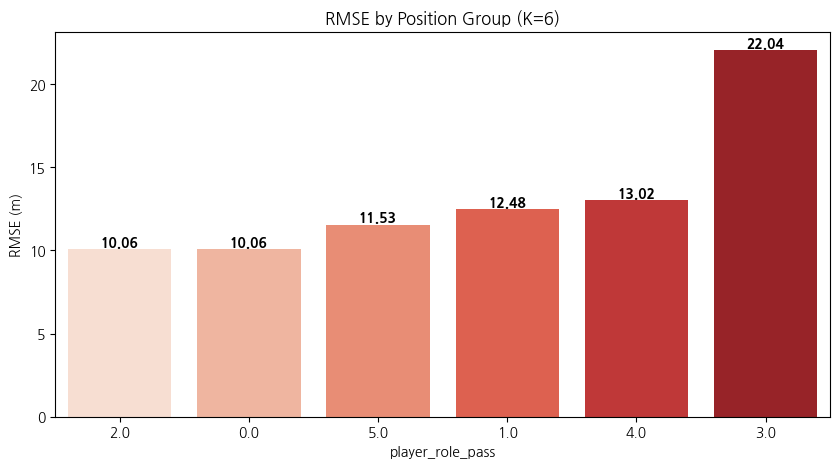

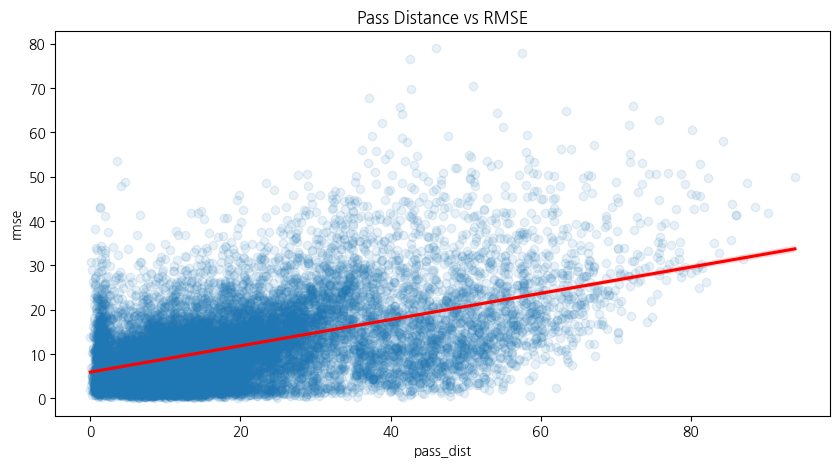

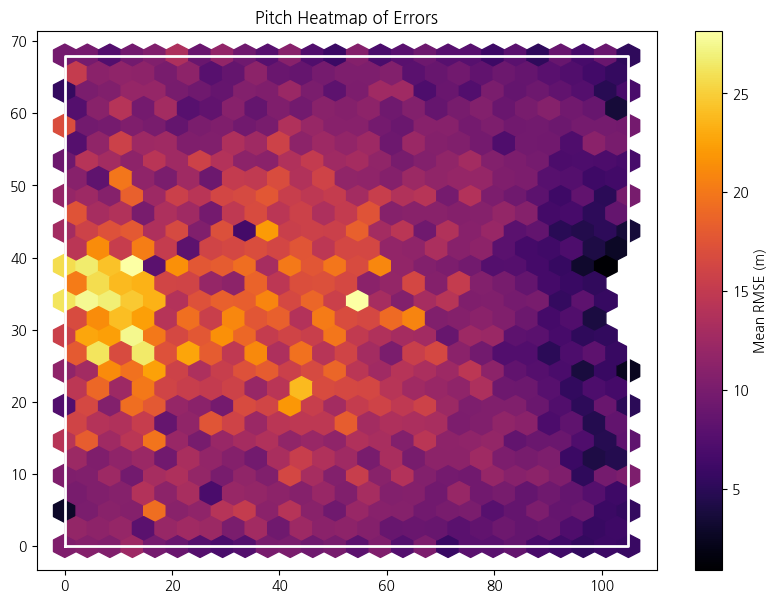

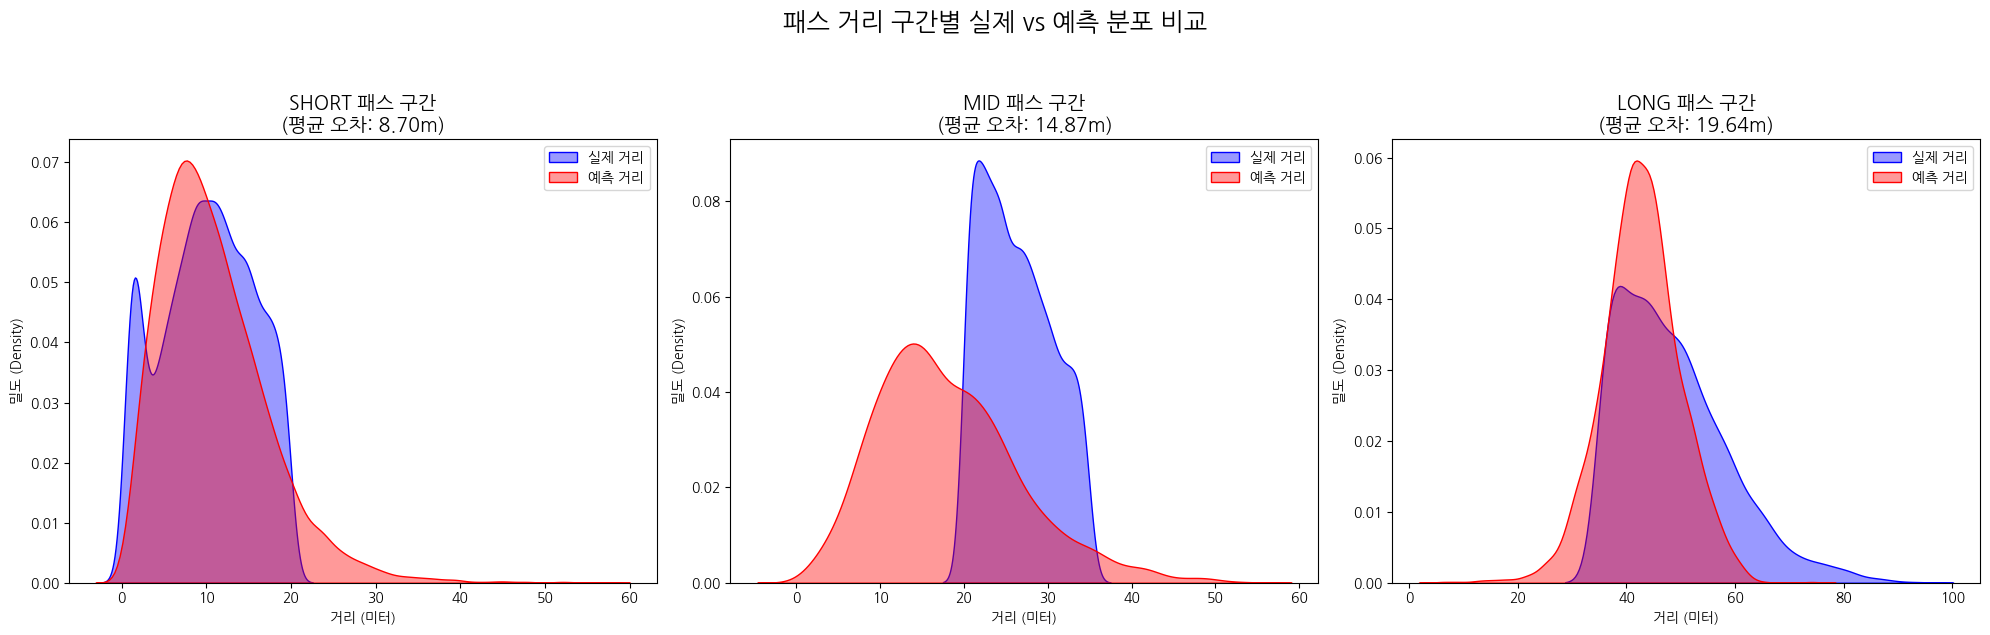

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from catboost import CatBoostRegressor

# =============================================================================
# 1. Config (13.15m 신기록 세팅)
# =============================================================================
class Config:
    SEED = 42
    N_FOLDS = 5
    CLIP_X = (0, 105)
    CLIP_Y = (0, 68)

    # Base 모델
    BASE_PARAMS = {
        'depth' :10,
        'learning_rate' : 0.0222,
        'l2_leaf_reg' : 2.80,
        'rsm' : 0.6716,
        'bagging_temperature' : 0.121,
        'iterations' : 6000,
        'early_stopping_rounds' : 200
    }

    # Fixer 모델
    FIXER_PARAMS = {
        'depth' : 7,
        'learning_rate' : 0.0339,
        'l2_leaf_reg' : 26.74,
        'rsm' : 0.9103,
        'bagging_temperature' : 0.4276,
        'loss_function' : 'MAE',
        'early_stopping_rounds' : 250
    }

# =============================================================================
# 2. 데이터 전처리 (Merge 포함)
# =============================================================================
def build_dataset(df_copy):
    print(f"[Data] 데이터셋 구축 중... (사용 피처 수: {len(FEATURE_CANDIDATES)})")

    # 1. 포지션 라벨 이름 불일치 방지 (KeyError 방어)
    if 'player_role_pass' not in df_copy.columns and 'player_role_pass_id' in df_copy.columns:
        df_copy['player_role_pass'] = df_copy['player_role_pass_id']

    # 2. 상세 스탯 Merge (player_stats_flat 활용)
    # 이미 Merge 되어 있을 수도 있으니 없는 컬럼만 Merge
    player_features = player_stats_flat[[
        'pass_dist_mean', 'pass_dist_std', 'forward_mean',
        'side_move_mean', 'dx_mean', 'dy_mean'
    ]].copy()

    cols_to_merge = [c for c in player_features.columns if c not in df_copy.columns]
    if cols_to_merge:
        df_copy = df_copy.merge(player_features[cols_to_merge], on='player_id', how='left').fillna(0)

    # 3. 전처리 파이프라인
    df = add_episode_len(df_copy)
    df_train, df_test = split_train_test(df, "is_train")
    df_train, df_test = sort_df(df_train), sort_df(df_test)

    train_epi = filter_train_targets(get_last_event_per_episode(df_train))
    test_epi  = get_last_event_per_episode(df_test)

    # 4. 피처 추출 (사용자님이 정의한 리스트 사용)
    X_train = train_epi[FEATURE_CANDIDATES].copy()
    X_test  = test_epi[FEATURE_CANDIDATES].copy()

    # 5. 범주형 피처 처리 및 결측치 채우기
    # CAT_CANDIDATES에 있는 것들 중 실제 피처 리스트에 있는 것만 골라냄
    actual_cat_features = [c for c in CAT_CANDIDATES if c in FEATURE_CANDIDATES]
    X_train, X_test = fill_missing(X_train, X_test, actual_cat_features)

    # 6. 타겟 변수 계산 (변위 기반)
    y_dx = train_epi["end_x"].values - train_epi["start_x"].values
    y_dy = train_epi["end_y"].values - train_epi["start_y"].values

    groups = train_epi["game_id"].values

    return X_train, X_test, y_dx, y_dy, groups, test_epi, actual_cat_features

# =============================================================================
# 3. 학습 및 OOF 데이터 생성 (수정됨)
# =============================================================================
def train_long_model(X_train, y_dx, y_dy, cat_features):
    # long 정의 (OOF 기준과 동일)
    pass_dist = np.sqrt(y_dx**2 + y_dy**2)
    mask_long = pass_dist >= 35

    X_long = X_train[mask_long]
    y_dx_long = y_dx[mask_long]
    y_dy_long = y_dy[mask_long]

    print(f"[LONG] samples: {len(X_long)}")

    LONG_PARAMS = {
        'depth': 7,
        'learning_rate': 0.03,
        'iterations': 1200,
        'loss_function': 'RMSE',
        'early_stopping_rounds': 100,
        'random_seed': 42,
        'verbose': 200
    }

    model_dx = CatBoostRegressor(**LONG_PARAMS)
    model_dy = CatBoostRegressor(**LONG_PARAMS)

    model_dx.fit(X_long, y_dx_long, cat_features=cat_features)
    model_dy.fit(X_long, y_dy_long, cat_features=cat_features)

    return model_dx, model_dy

def train_residual_pipeline(X_train, y_dx, y_dy, X_test, groups, cat_features):
    gkf = GroupKFold(n_splits=Config.N_FOLDS)

    # 예측값 저장소
    oof_base_dx = np.zeros(len(X_train))
    oof_base_dy = np.zeros(len(X_train))
    oof_fix_dx = np.zeros(len(X_train))
    oof_fix_dy = np.zeros(len(X_train))

    test_total_dx = np.zeros(len(X_test))
    test_total_dy = np.zeros(len(X_test))

    # 중요도 저장
    fi_df = pd.DataFrame(index=X_train.columns)
    fi_df['importance'] = 0

    print("\n===== [Start] 5-Fold Training =====")

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_train, y_dx, groups=groups), 1):
        print(f"\n--- Fold {fold} ---")

        # 1. Base Model
        model_dx = CatBoostRegressor(**Config.BASE_PARAMS)
        model_dy = CatBoostRegressor(**Config.BASE_PARAMS)

        model_dx.fit(X_train.iloc[tr_idx], y_dx[tr_idx], eval_set=[(X_train.iloc[va_idx], y_dx[va_idx])], cat_features=cat_features, verbose=200)
        model_dy.fit(X_train.iloc[tr_idx], y_dy[tr_idx], eval_set=[(X_train.iloc[va_idx], y_dy[va_idx])], cat_features=cat_features, verbose=200)

        # 모델 저장
        model_dx.save_model(f"model_dx_fold{fold}.cbm")
        model_dy.save_model(f"model_dy_fold{fold}.cbm")

        # OOF 예측 (검증용)
        train_pass_dist = np.sqrt(y_dx[tr_idx]**2 + y_dy[tr_idx]**2)
        val_pass_dist   = np.sqrt(y_dx[va_idx]**2 + y_dy[va_idx]**2)

        mask_long_tr = train_pass_dist >= 35
        mask_long_va = val_pass_dist   >= 35

        # 2) fold 내부 long 모델 학습
        if mask_long_tr.sum() > 50:
            long_dx_model, long_dy_model = train_long_model(
                X_train.iloc[tr_idx][mask_long_tr],
                y_dx[tr_idx][mask_long_tr],
                y_dy[tr_idx][mask_long_tr],
                cat_features
            )
        else:
            long_dx_model = None
            long_dy_model = None

# 3) 기본 예측
        val_dx = model_dx.predict(X_train.iloc[va_idx])
        val_dy = model_dy.predict(X_train.iloc[va_idx])

# 4) long만 교체
        if long_dx_model is not None:
            val_dx[mask_long_va] = long_dx_model.predict(
            X_train.iloc[va_idx][mask_long_va]
             )
            val_dy[mask_long_va] = long_dy_model.predict(
            X_train.iloc[va_idx][mask_long_va]
            )

# 5) OOF 저장
        oof_base_dx[va_idx] = val_dx
        oof_base_dy[va_idx] = val_dy

        # Test 예측 (제출용)
        test_total_dx += model_dx.predict(X_test) / Config.N_FOLDS
        test_total_dy += model_dy.predict(X_test) / Config.N_FOLDS

        # 중요도 누적
        fi_df['importance'] += model_dx.get_feature_importance() / Config.N_FOLDS

        # 2. Fixer Model (잔차 학습)
        train_dx_pred = model_dx.predict(X_train.iloc[tr_idx])
        train_dy_pred = model_dy.predict(X_train.iloc[tr_idx])

        resid_dx_train = y_dx[tr_idx] - train_dx_pred
        resid_dy_train = y_dy[tr_idx] - train_dy_pred

        resid_dx_val = y_dx[va_idx] - val_dx
        resid_dy_val = y_dy[va_idx] - val_dy

        fixer_dx = CatBoostRegressor(**Config.FIXER_PARAMS)
        fixer_dy = CatBoostRegressor(**Config.FIXER_PARAMS)

        fixer_dx.fit(X_train.iloc[tr_idx], resid_dx_train, eval_set=[(X_train.iloc[va_idx], resid_dx_val)], cat_features=cat_features, verbose=200)
        fixer_dy.fit(X_train.iloc[tr_idx], resid_dy_train, eval_set=[(X_train.iloc[va_idx], resid_dy_val)], cat_features=cat_features, verbose=200)

        oof_fix_dx[va_idx] = fixer_dx.predict(X_train.iloc[va_idx])
        oof_fix_dy[va_idx] = fixer_dy.predict(X_train.iloc[va_idx])

        test_total_dx += fixer_dx.predict(X_test) / Config.N_FOLDS
        test_total_dy += fixer_dy.predict(X_test) / Config.N_FOLDS

    # 최종 OOF 결과 (분석용 데이터) 만들기
    final_oof_dx = oof_base_dx + oof_fix_dx
    final_oof_dy = oof_base_dy + oof_fix_dy

    # 분석을 위해 X_train에 실제값과 예측값을 붙여서 리턴
    oof_df = X_train.copy()
    oof_df['true_dx'] = y_dx
    oof_df['true_dy'] = y_dy
    oof_df['pred_dx'] = final_oof_dx
    oof_df['pred_dy'] = final_oof_dy
    oof_df['pass_dist'] = np.sqrt(oof_df['true_dx']**2 + oof_df['true_dy']**2)

    # 점수 계산
    err_x = (y_dx - final_oof_dx) ** 2
    err_y = (y_dy - final_oof_dy) ** 2
    score = np.mean(np.sqrt(err_x + err_y))
    print(f"\n[OOF] 최종 점수: {score:.4f}m")

    return test_total_dx, test_total_dy, fi_df, oof_df

# =============================================================================
# 4. 실행 및 정밀 분석 그래프 출력
# =============================================================================
# 데이터셋 준비
X_train, X_test, y_dx, y_dy, groups, test_epi, cat_features = build_dataset(df_copy)

# 학습 실행 (반환값 4개: 예측X, 예측Y, 중요도, OOF분석데이터)
pred_dx, pred_dy, fi_df, oof_df = train_residual_pipeline(X_train, y_dx, y_dy, X_test, groups, cat_features)

# [OOF Post Process] Carry Hard Distance Cap

def apply_carry_hard_caps(dx, dy, df_like, caps):
    dx = dx.copy()
    dy = dy.copy()

    pred_dist = np.sqrt(dx**2 + dy**2)

    for role, cap in caps.items():
        mask = (
            (df_like['player_role_pass'] == role) &
            (df_like['prev1_action_type'] == 'Carry') &
            (pred_dist > cap)
        )
        if mask.sum() == 0:
            continue

        scale = cap / pred_dist[mask]
        dx[mask] *= scale
        dy[mask] *= scale

    return dx, dy

# ---------- 1. Build caps from OOF ----------
is_carry = oof_df['prev1_action_type'] == 'Carry'
caps = (
    oof_df[is_carry]
    .groupby('player_role_pass')['pass_dist']
    .quantile(0.95)
)
# ---------- 2. Apply to OOF ----------
dx0 = oof_df['pred_dx'].values.copy()
dy0 = oof_df['pred_dy'].values.copy()

dx1, dy1 = apply_carry_hard_caps(dx0, dy0, oof_df, caps)

# ---------- 3. OOF Score Check ----------
err_before = np.sqrt((oof_df['true_dx'] - dx0)**2 + (oof_df['true_dy'] - dy0)**2)
err_after  = np.sqrt((oof_df['true_dx'] - dx1)**2 + (oof_df['true_dy'] - dy1)**2)

print("\nCarry Caps OOF Test")
print(f"Before RMSE : {err_before.mean():.4f}")
print(f"After  RMSE : {err_after.mean():.4f}")
print(f"Gain        : {err_before.mean() - err_after.mean():.4f}")

# 3) Gain이 플러스일 때만 OOF/TEST에 반영
if err_after.mean() < err_before.mean():
    print("hard cap 적용 (OOF/Test)")
    oof_df['pred_dx'] = dx1
    oof_df['pred_dy'] = dy1

    pred_dx, pred_dy = apply_carry_hard_caps(pred_dx, pred_dy, test_epi, caps)
else:
    print("Hard cap이 OOF를 악화시켜서 적용 안 함")

# ---------- 4. Apply to Test ----------
if err_after.mean() < err_before.mean():
    pred_dx, pred_dy = apply_carry_hard_caps(pred_dx, pred_dy, test_epi, caps)

# ---------- 5. Build Submission ----------
final_pred_x = np.clip(test_epi["start_x"].values + pred_dx, *Config.CLIP_X)
final_pred_y = np.clip(test_epi["start_y"].values + pred_dy, *Config.CLIP_Y)

submission = pd.DataFrame({
    "game_episode": test_epi["game_episode"].values,
    "end_x": final_pred_x,
    "end_y": final_pred_y
})
submission.to_csv("sub.csv", index=False)
print("제출 파일 저장 완료.")

# [ EDA] OOF 데이터로 분석

print("\n모델 오차 분석")

# 오차 계산
oof_df['error_sq'] = (oof_df['true_dx'] - oof_df['pred_dx'])**2 + (oof_df['true_dy'] - oof_df['pred_dy'])**2
oof_df['rmse'] = np.sqrt(oof_df['error_sq'])
oof_df['pass_dist'] = np.sqrt(oof_df['true_dx']**2 + oof_df['true_dy']**2)

# ===== 여기부터 추가 기존 13.14 코드에 mid, short, long 패스 EDA =====
def bucket(d):
    if d < 20:
        return 'short'
    elif d < 35:
        return 'mid'
    else:
        return 'long'

oof_df['bucket'] = oof_df['pass_dist'].apply(bucket)

print(oof_df.groupby('bucket')['rmse'].mean())
print(oof_df.groupby('bucket')['rmse'].count())
# ===== 여기까지 =====

# [그래프 1] 포지션별 오차 (누가 문제인가?)
plt.figure(figsize=(10, 5))
role_error = oof_df.groupby('player_role_pass')['rmse'].mean().sort_values()
sns.barplot(x=role_error.index, y=role_error.values, palette='Reds')
plt.title('RMSE by Position Group (K=6)')
plt.ylabel('RMSE (m)')
for i, v in enumerate(role_error.values):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
plt.show()

# [그래프 2] 거리별 오차 (멀리 찰수록 틀리나?)
plt.figure(figsize=(10, 5))
sns.regplot(x='pass_dist', y='rmse', data=oof_df, scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
plt.title('Pass Distance vs RMSE')
plt.show()

# [그래프 3] 경기장 위치별 오차 (어디서 틀리나?)
plt.figure(figsize=(10, 7))
plt.hexbin(oof_df['start_x'], oof_df['start_y'], C=oof_df['rmse'], gridsize=25, cmap='inferno', reduce_C_function=np.mean)
plt.colorbar(label='Mean RMSE (m)')
plt.title('Pitch Heatmap of Errors')
plt.plot([0, 105, 105, 0, 0], [0, 0, 68, 68, 0], 'w-', lw=2)
plt.show()

def plot_all_buckets_comparison(oof_df):

    buckets = ['short', 'mid', 'long']
    # 3개의 그래프를 가로로 나란히 배치
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for i, bucket in enumerate(buckets):
        # 해당 구간 데이터 필터링
        data = oof_df[oof_df['bucket'] == bucket]

        if len(data) == 0:
            axes[i].set_title(f"{bucket} 데이터 없음")
            continue

        # 실제 거리와 예측 거리 계산
        actual_dist = np.sqrt(data['true_dx']**2 + data['true_dy']**2)
        pred_dist = np.sqrt(data['pred_dx']**2 + data['pred_dy']**2)

        # 평균 RMSE 계산 (제목에 표시용)
        avg_rmse = data['rmse'].mean()

        # KDE Plot 그리기
        sns.kdeplot(actual_dist, label='실제 거리', fill=True, color='blue', ax=axes[i], alpha=0.4)
        sns.kdeplot(pred_dist, label='예측 거리', fill=True, color='red', ax=axes[i], alpha=0.4)

        # 그래프 꾸미기
        axes[i].set_title(f"{bucket.upper()} 패스 구간\n(평균 오차: {avg_rmse:.2f}m)", fontsize=14)
        axes[i].set_xlabel("거리 (미터)")
        axes[i].set_ylabel("밀도 (Density)")
        axes[i].legend()

    plt.suptitle("패스 거리 구간별 실제 vs 예측 분포 비교", fontsize=18, y=1.05)
    plt.tight_layout()
    plt.show()

# 실행
plot_all_buckets_comparison(oof_df)



In [38]:
oof_df['prev1_action_type'].value_counts().head(20)

,count
prev1_action_type,
Carry,6160
Pass,5814
Recovery,1834
Tackle,459
Throw-In,373
Interception,301
Duel,158
Pass_Corner,98
Cross,73


In [39]:
is_carry = oof_df['prev1_action_type'] == 'Carry'
oof_df[is_carry]['pass_dist'].describe()

,pass_dist
count,6160.000000
mean,24.997733
std,17.860175
min,0.162339
25%,11.117699
50%,20.184236
75%,36.832788
max,90.354131


In [40]:
oof_df[is_carry].groupby('player_role_pass')['pass_dist'].describe()

,count,mean,std,min,25%,50%,75%,max
player_role_pass,,,,,,,,
0.0,965.0,16.818228,13.049255,0.214603,8.042590,13.643115,22.546505,75.837213
1.0,2064.0,26.636115,16.877470,0.185345,13.274551,23.088434,39.499495,80.133745
2.0,1234.0,17.146379,12.050284,0.175583,8.923309,14.557078,22.613840,75.951060
3.0,442.0,51.402593,15.590752,1.323779,42.863890,51.953665,61.985421,90.354131
4.0,610.0,29.396609,18.101295,0.622254,14.239069,27.318177,43.117306,78.507652
5.0,845.0,24.815382,17.581360,0.162339,11.551551,20.161399,37.277916,88.552441


In [41]:
pred_dist = np.sqrt(oof_df['pred_dx']**2 + oof_df['pred_dy']**2)

pd.DataFrame({
    'true': oof_df.loc[is_carry, 'pass_dist'],
    'pred': pred_dist[is_carry]
}).describe()

,true,pred
count,6160.000000,6160.000000
mean,24.997733,23.176856
std,17.860175,14.919045
min,0.162339,0.043248
25%,11.117699,11.383247
50%,20.184236,18.219361
75%,36.832788,36.763750
max,90.354131,65.011914


In [42]:
oof_df[is_carry].groupby('player_role_pass')['pass_dist'].describe()

,count,mean,std,min,25%,50%,75%,max
player_role_pass,,,,,,,,
0.0,965.0,16.818228,13.049255,0.214603,8.042590,13.643115,22.546505,75.837213
1.0,2064.0,26.636115,16.877470,0.185345,13.274551,23.088434,39.499495,80.133745
2.0,1234.0,17.146379,12.050284,0.175583,8.923309,14.557078,22.613840,75.951060
3.0,442.0,51.402593,15.590752,1.323779,42.863890,51.953665,61.985421,90.354131
4.0,610.0,29.396609,18.101295,0.622254,14.239069,27.318177,43.117306,78.507652
5.0,845.0,24.815382,17.581360,0.162339,11.551551,20.161399,37.277916,88.552441
